# Влияние learning rate и масштаба признаков на сходимость

In [1]:
import tensorflow as tf
print("TF", tf.__version__)
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML, display_html
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output, display_html, HTML
import contextlib
import time
import io
import urllib
import base64
import keras
from keras import backend as K

Init Plugin
Init Graph Optimizer
Init Kernel
TF 2.5.0


In [2]:
def clear_and_display_figure(fig, sleep=0.01):
    img_data = io.BytesIO()
    fig.savefig(img_data, format='jpeg')
    img_data.seek(0)
    uri = 'data:image/jpeg;base64,' + urllib.request.quote(base64.b64encode(img_data.getbuffer()))
    img_data.close()
    clear_output(wait=True)
    display_html(HTML('<img src="' + uri + '">'))
    time.sleep(sleep)

# запись анимации для Колаба
class SimpleMovieWriter(object):
    """
    Usage example:
        anim = animation.FuncAnimation(...)
        anim.save(None, writer=SimpleMovieWriter(sleep=0.01))
    """
    def __init__(self, sleep=0.1):
        self.sleep = sleep

    def setup(self, fig):
        self.fig = fig

    def grab_frame(self, **kwargs):
        clear_and_display_figure(self.fig, self.sleep)

    @contextlib.contextmanager
    def saving(self, fig, *args, **kwargs):
        self.setup(fig)
        try:
            yield self
        finally:
            pass
          
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [4]:
# скидываем сессию
s = reset_tf_session()

AttributeError: module 'tensorflow' has no attribute 'get_default_session'

Лосс на одном объекте: $l = (x_1 w_1 + x_2 w_2 - y)^2$

[Каноническое уравнение эллипса](https://ru.wikipedia.org/wiki/Эллипс): $\frac{x_1^2}{a^2} + \frac{x_2^2}{b^2} = 1$, поэтому [линии уровня](https://foxford.ru/wiki/matematika/metod-liniy-urovnya) лосса так выглядят.

Если мы будем увеличивать масштаб $x_1$, это будет сплющивать ось $w_1$ на графике линий уровня.

Разные по масштабу градиенты если разный масштаб признаков:

$ \frac{dl}{dw_1} = 2 (x_1 w_1 + x_2 w_2 - y) x_1$

$ \frac{dl}{dw_2} = 2 (x_1 w_1 + x_2 w_2 - y) x_2$

<a list of 22 text.Text objects>

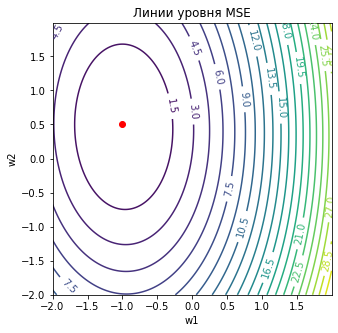

In [5]:
# генерируем простой датасет
np.random.seed(42)
N = 100
x = np.random.randn(N, 2)
w = np.array([[-1, 0.5]]).T
x[:, 0] *= 2  # признак x1 в x_scale раз больше (создает долины в лоссе)
y = x @ w + np.random.randn(N, 1) * 0.2
    
# рисуем линии уровня лосса в пространстве весов
fig, ax = plt.subplots(figsize=(5, 5))
W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
contour = ax.contour(W1, W2, Z, 20)
ax.scatter(*w, c='red')
plt.xlabel('w1')
plt.ylabel('w2')
plt.title(u"Линии уровня MSE")
ax.clabel(contour, inline=1, fontsize=10)

In [6]:
# визуализация шагов
def plot_gd(x_scale, lr, steps, optimizer='sgd'):
    # генерируем простой датасет
    np.random.seed(42)
    N = 100
    x = np.random.randn(N, 2)
    w = np.array([[-1, 0.5]]).T
    x[:, 0] *= x_scale  # признак x1 в x_scale раз больше (создает долины в лоссе)
    y = x @ w + np.random.randn(N, 1) * 0.2
    
    # оптимизация в TF
    w_guess = tf.Variable([1.5, 1.5], dtype='float32')  
    loss = tf.reduce_mean((tf.constant(x, tf.float32) * w_guess - tf.constant(y, tf.float32)) ** 2)
    if optimizer == 'sgd':
        step = tf.train.GradientDescentOptimizer(lr).minimize(loss, var_list=w_guess)
    elif optimizer == 'adam':
        step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=w_guess)

    # рисуем линии уровня лосса в пространстве весов
    fig, ax = plt.subplots(figsize=(5, 5))
    W1, W2 = np.meshgrid(np.arange(-2, 2, 0.01), np.arange(-2, 2, 0.01))
    Z = np.mean((x.dot(np.vstack([W1.ravel(), W2.ravel()])) - y)**2, axis=0).reshape(W1.shape)
    contour = ax.contour(W1, W2, Z, 20)
    ax.scatter(*w, c='red')
    ax.clabel(contour, inline=1, fontsize=10)
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.title(u"Линии уровня MSE")
    line, = ax.plot([], [], lw=2)
    
    s.run(tf.global_variables_initializer())

    # стартуем анимацию с пустой траекторией
    def init():
        line.set_data([], [])
        return (line,)

    trajectory = [s.run(w_guess)]

    # один шаг анимации (шаг бекпроп)
    def animate(i):
        s.run(step)
        trajectory.append(s.run(w_guess))
        line.set_data(*zip(*trajectory))
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=steps, interval=20, blit=True)

    anim.save(None, writer=SimpleMovieWriter(0.0001))

# Простой SGD

У наивного SGD есть проблемы, он плохо сходится когда производные по разным весам слишком разные по масштабу!

In [7]:
plot_gd(x_scale=1.0, lr=0.1, steps=25)

Metal device set to: Apple M1


2022-03-21 14:18:32.653375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 14:18:32.653716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

In [8]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

In [9]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

In [10]:
# попробуем шаг побольше?
# w0 меняется быстрее, но w1 меняется слишком быстро, приводит к осциллированию
plot_gd(x_scale=0.2, lr=2.0, steps=25)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

# Adam

Адам работает как зайка, ему не важен масштаб признаков, у него адаптивный learning rate и инерция!

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivM/2kvjn4x%2BDs3gXw18OPh7pniXxD4%2B8Z/8ACP6TYax4jk0u2iK6bf6jLPJPFa3ThVhsJBgRHJZeRXJ/B39vj4ZeLfg8fiP8aXsPBGpWWk%2BJtV1zSo7641C2s9P0PVpdMvLpbr7NF5ieYkbBTGkhEoARtpNAHvFFeXWv7Z/7NV74P1Px9a/EndpOj6Xouo6jd/2PeDybbVlRtPk2mHc3miRDhQWTPzhMGrMv7XP7O0PiXw/4Ol%2BJMK6p4q8Y6n4W0CxNhc%2BZearp/nfbYAPL%2BVYvIkBmbEROwByZEDAHpFFeb/Dn9rn9nb4t%2BLfDHgT4e/EmHUdY8ZfDiLx74dsFsLmOS58OyPBHHfN5ka%2BSGe5hAjk2SHc3yfI%2B23d/tN/A%2BytdSurrxtt/sjx1aeDdQh/sy5MsWt3L2yQWnliPe2/7XbuJFBjEcnmlxGGcAHe0V4p8P/8Agol%2Bx18TfDb%2BMvC3xeZNHHg2XxXBq2seHdR021u9Gi8vz7u3lvLeJLlYmliSURF2ieRUkCswWrNz%2B3r%2BzHZeHZPEV54o8RRNDr9pokmiyfD3W11cX11E01tH/Zps/tmJY0dkk8nYwRsMcGgD2KivNPB/7YP7O3jzyE8MeP3mln0DV9Z%2BzT6LewTQ2ml3aWeoedFLCrwSwXEiRPBIFmDZGw7Wxhan/wAFB/2T9Lk04P4%2B1a5h1O30WaO/03wRrF3aWq6uYhpou7iC0eKyeczw7UuGjYCRSQAQaAPaKK8Y/ai/bAs/2YviT8LPBms%2BBH1LTfiL4qOjahrSal5P9hhjFFDcNH5becjXE8EbfNHsVzISQpB4v4tf8FK/DHwo%2BLHxc8AXfwwur7S/hJ4Gt9a1LXodWRBd30hhL2XltHtijiiurSR7lpCqiSTKDyiSAfTdFfOfjT9sn45fDX4KeJfjD4w/Z08L3trpunadc%2BG9S8JfFIajo%2BsPdXqWnkNdtp8U0EiGRZCy200bIeH3ZUer/DDXf2i9W1O5i%2BNHwr8FaBZpADZz%2BF/H95q8ssu4ZV459KsxGuMncHY54296AO1ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKy/F2o6zpOjm/0VLZpElXzPtQYqEPBICkZOSO/rQldgalFcaPiHreObW1/74b/AOKo/wCFiayTgW1px/sN/wDFVr7GYro7KiuMb4i6wo3Nb2gHqUb/AOKqJvilqYO2O2t5D6JEx/8AZqTpSW4XR3FFcVdfEXxIl1JBDpFuirIQPPBDDB6EButJF8Q/E2czW9jjuFif/wCKpKnN7ILo7aiuN/4WHrX/AD62v/fDf/FUf8LD1r/n1tf%2B%2BG/%2BKqvYzDmR2VFcm/jvWF0%2BK7FvbbnmkQjY2MKEI/i/2jUP/Cw9a/59bX/vhv8A4qj2MwujC8f/AAg8bfED9p3wD8SL%2BfS4fCfgHT9SvrVFu5HvrvWruE2a5i8oRxwRWklz8/mM7vc7diCPdJ88aV/wTT%2BL954h8HWvi7xn4abw3otv41fxFp1rcXDvqk2o%2BJjrWlQ/NCoEMci28s5JzvthGFkjdmr6jf4h66V/d21oD2LRsf8A2aoT8RfFSnJsrBh6Krg/q1J0proF0fJ03/BKX4j6p8ONZ0nWPHNsmuy%2BDvAGk6MNM8c6zaaaZtEigS8a7tYAkNyjmNvJMsUp5GRH263wL/wT0%2BKWjfHCH40%2BLvF3h%2B9uNO%2BOup%2BJdCt4Zp8af4cuhqszQpui5vZrrUImmAxGY7SAByYgW%2BiLb4mawZCt5pcaARucxxM3IUkdG6Zxn2pIvibqU3%2BrjtCfTYwP/oVJU5N2C588/sF/8E9fil%2By5qfwm8XfEzxd4f1jXvCfwe1bwl4xvtLmnKzTOfDMGmxWgkiUm1htNCkVy3lkzTGQR5mk2KPhbY/Ej/gqzd674I8XWOo%2BE/DeiWPiTx7pVm3miz8YwW93plgJWU7RK%2BnXbyNE2XT%2Bz7OQhQ6E/RP/AAsPWv8An1tf%2B%2BG/%2BKo/4WHrX/Pra/8AfDf/ABVV7GYcyPhD9lj9jP48/tYfsF/A6XxVrXhHw/pPh/8AZ0isPBF9p15c3Vxf3t9FpNzBJfW7QRLbwwjT0jdI5pjOZWfMW0IfVfjh%2BxD%2B098dvE198avEll4NsfEt54p8KTf8ItonxJ1jT7ZNM0VNVbK6xbWEd1FdSzatMcx26hUiRd7ck/SbfEfxPCWeSysmRVYjZG%2BT3HVuP89KZdfFDXUnitrO3sZi8CM7qjbQ7IrEZDds4qXTkgufMHhD/gl98Q7j%2Byh8Q/GaW1vp/gjxvp9vZ%2BGPiHrdrPbXms61b6haxTX9v9nuNVijjjlE9xdfvJ5SJHikYlhBcf8ABLj4n694QsjrPi/TNO1rRNG%2BHOl6dY6B4u1W30vU/wCwbmxuL6/1GGNEjvLh1hmt7ZZYZFSOCBiyNIfJ%2Bprf4raq6hZre0D7sEpE5HUgH73AOO9LqnxF8Xra79GstOaYMDsnR8MO4BDcH3p%2BynYLo4v9rz9k28/al1nw7YXWr2tnotnoXiLTtVlMrrdRNqFgLeCe2CqR5kUgEgJZSpVSuSK89%2BE37GH7Tnw0jk8f/wDCd%2BB7rx3q3gC5h8T317aXFzYX3iC81ptSvEMWxGNiY3e0jckSRxrGfKOzafbtI%2BM2oalKbG4sLe1vEH7y1mRg31B3fMPcVrp471htPluzb225Jo0A2NjDByf4v9kUKlJoLo%2BRPHP/AATR%2BJPjTw78RpfBnwd%2BEXw1/wCEx8L2WmzfD/wlr13LoWvXkWq2161/qDDTLdIpRFBJbqUtJWZbiQu7Daq%2B/fswfBXUvhH4j1OWL9jP4LfDCzv7JRPf/C/WzPc3siOPLimj/sWxBjAaRgxkcg8BPmLDr9O%2BIXi8JL/a1vppbzm8k28UgHl/w7sufm9ccVYPxE1kDJtrX/vhv/iqfsZhdHZUV5Pe/HrxX4Y8SnTfGWk6fDp13Lt0zVYI38sH/nnNlztb0bofbBrq9P8AHes3t9BaGC1AllVNwjbjJAz96l7KYXR1tFeP%2BD/2hvFs3iKbwD8QdH06w1tN0lo1ukgt9Qhzw8JZycgfeQnIxn1xo/EX4qfFPR/DEurfD7w9pWoX9tIsj2F0sgNxCD86RsrjbIR90nIz1Bo9lNq4XR6fRXl/gf8AaAPxM8Ir4l8ItaKZFaNo7m2cvaTgYMcsYcEMp6rkZHQ4INc9r37RvxQ8C6BMfEPhmw1fWpGmazsdI06eGGOCIDfPNI0smI%2BQ2QN3zBFVmBNHsp2uF0e40V4H45/aR%2BO2ifDc%2BN/Cnw60bUrnTrxZ7/T4nmc6ppm0O8tkSUbzArLgOpBKOBuytdh4L

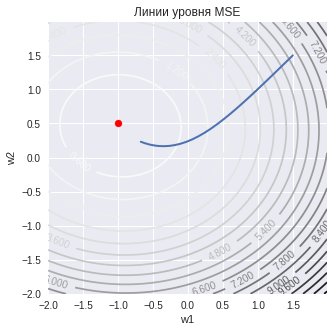

In [0]:
plot_gd(x_scale=1.0, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivM/2kvjn4x%2BDs3gXw18OPh7pniXxD4%2B8Z/8ACP6TYax4jk0u2iK6bf6jLPJPFa3ThVhsJBgRHJZeRXJ/B39vj4ZeLfg8fiP8aXsPBGpWWk%2BJtV1zSo7641C2s9P0PVpdMvLpbr7NF5ieYkbBTGkhEoARtpNAHvFFeXWv7Z/7NV74P1Px9a/EndpOj6Xouo6jd/2PeDybbVlRtPk2mHc3miRDhQWTPzhMGrMv7XP7O0PiXw/4Ol%2BJMK6p4q8Y6n4W0CxNhc%2BZearp/nfbYAPL%2BVYvIkBmbEROwByZEDAHpFFeb/Dn9rn9nb4t%2BLfDHgT4e/EmHUdY8ZfDiLx74dsFsLmOS58OyPBHHfN5ka%2BSGe5hAjk2SHc3yfI%2B23d/tN/A%2BytdSurrxtt/sjx1aeDdQh/sy5MsWt3L2yQWnliPe2/7XbuJFBjEcnmlxGGcAHe0V4p8P/8Agol%2Bx18TfDb%2BMvC3xeZNHHg2XxXBq2seHdR021u9Gi8vz7u3lvLeJLlYmliSURF2ieRUkCswWrNz%2B3r%2BzHZeHZPEV54o8RRNDr9pokmiyfD3W11cX11E01tH/Zps/tmJY0dkk8nYwRsMcGgD2KivNPB/7YP7O3jzyE8MeP3mln0DV9Z%2BzT6LewTQ2ml3aWeoedFLCrwSwXEiRPBIFmDZGw7Wxhan/wAFB/2T9Lk04P4%2B1a5h1O30WaO/03wRrF3aWq6uYhpou7iC0eKyeczw7UuGjYCRSQAQaAPaKK8Y/ai/bAs/2YviT8LPBms%2BBH1LTfiL4qOjahrSal5P9hhjFFDcNH5becjXE8EbfNHsVzISQpB4v4tf8FK/DHwo%2BLHxc8AXfwwur7S/hJ4Gt9a1LXodWRBd30hhL2XltHtijiiurSR7lpCqiSTKDyiSAfTdFfOfjT9sn45fDX4KeJfjD4w/Z08L3trpunadc%2BG9S8JfFIajo%2BsPdXqWnkNdtp8U0EiGRZCy200bIeH3ZUer/DDXf2i9W1O5i%2BNHwr8FaBZpADZz%2BF/H95q8ssu4ZV459KsxGuMncHY54296AO1ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKxfHnia/8ACegnVdN0Se/lMyxiKBAdoOfmbJGBxjPqRQtWBtUV5h/wuP4mTf8AHt8O7ZR2a4vQv6Ak0f8ACyvjDNzHovh6AekrzOf/AB0ir9nPsK6PT6K82h8ffFdv%2BPiTw8v%2B5ZTt/OUVqQ/ETXhGiXENk0u0bykTgE9yAXOB%2BJpqlN9AujtaK5C7%2BIWox309vaLZypDOyBlBPQ45w1M/4WHrX/Pra/8AfDf/ABVNUZtBdHZUVxv/AAsPWv8An1tf%2B%2BG/%2BKo/4WHrX/Pra/8AfDf/ABVHsZhzI7KiuTfx3rC6fFdi3ttzzSIRsbGFCEfxf7RqH/hYetf8%2Btr/AN8N/wDFUexmF0YXj/4QeNviB%2B074B%2BJF/PpcPhPwDp%2BpX1qi3cj313rV3CbNcxeUI44IrSS5%2BfzGd3uduxBHuk%2BeNK/4Jp/F%2B88Q%2BDrXxd4z8NN4b0W38av4i061uLh31SbUfEx1rSofmhUCGORbeWck532wjCyRuzV9Sf8LD1r/n1tf%2B%2BG/wDiqP8AhYetf8%2Btr/3w3/xVHsZhzI%2BR5v8AglL8R9U%2BHGs6TrHjm2TXZfB3gDSdGGmeOdZtNNM2iRQJeNd2sASG5RzG3kmWKU8jIj7db4F/4J6fFLRvjhD8afF3i7w/e3GnfHXU/EuhW8M0%2BNP8OXQ1WZoU3Rc3s11qETTAYjMdpAA5MQLfSNj471i6naJ7e2AEMj8I3VUZh/F7Vj3nj74lec7afJofllj5azWM2QPciXn8qTpTC6PB/wBgv/gnr8Uv2XNT%2BE3i74meLvD%2Bsa94T%2BD2reEvGN9pc05WaZz4Zg02K0EkSk2sNpoUiuW8smaYyCPM0mxR8LbH4kf8FWbvXfBHi6x1Hwn4b0Sx8SePdKs280WfjGC3u9MsBKynaJX067eRomy6f2fZyEKHQn20/EX4xxnP2Hw1KPRVuEP6saT/AIW58VIOJvAenTepgvsfoxpezn2C6Pi39lj9jP48/tYfsF/A6XxVrXhHw/pPh/8AZ0isPBF9p15c3Vxf3t9FpNzBJfW7QRLbwwjT0jdI5pjOZWfMW0IfVfjh%2BxD%2B098dvE198avEll4NsfEt54p8KTf8ItonxJ1jT7ZNM0VNVbK6xbWEd1FdSzatMcx26hUiRd7ck%2B%2B/8Lz8WQf8f/w/uk9fIh80fo9SXP7QdlayBLy0ks8xoSL3TZkIJUE9D0znHtijkYXPm/wh/wAEvviHcf2UPiH4zS2t9P8ABHjfT7ez8MfEPW7We2vNZ1q31C1imv7f7PcarFHHHKJ7i6/eTykSPFIxLCC4/wCCXHxP17whZHWfF%2BmadrWiaN8OdL06x0Dxdqtvpep/2Dc2NxfX%2Bowxokd5cOsM1vbLLDIqRwQMWRpD5P09afHTT73H2fV9KJPRWcqfyLA1oRfEjVZk8yGKzdT0ZVYj/wBCpqlJ7BdHCftefsm3n7Uus%2BHbC61e1s9Fs9C8RadqspldbqJtQsBbwT2wVSPMikAkBLKVKqVyRXnvwm/Yw/ac%2BGkcnj//AITvwPdeO9W8AXMPie%2BvbS4ubC%2B8QXmtNqV4hi2IxsTG72kbkiSONYz5R2bT7/8A8LD1r/n1tf8Avhv/AIqpG8da4%2Blz3UMNosqSIke6JiuWVzkjcCeVHcU/YzC6Pkbxz/wTR%2BJPjTw78RpfBnwd%2BEXw1/4THwvZabN8P/CWvXcuha9eRarbXrX%2BoMNMt0ilEUElupS0lZluJC7sNqr79%2BzB8FdS%2BEfiPU5Yv2M/gt8MLO/slE9/8L9bM9zeyI48uKaP%2BxbEGMBpGDGRyDwE%2BYsNCb4mfHaymZk0nwtqEa9Y4fPgk/8AHnYD86b/AMND%2BMtO48S/C%2B9tvWSzi%2B1Rj3JR8/pU%2Bzl1C6PW6K8u0z9pTw5qsnkwa5psUucGK7R4WB9MSEc10eleP9T1K8t4FjtDHPKi741Y8EgZB3U/ZSaC511FcafiHreOLa1z2zG3/wAVXGXXxX/aQ0SdpZfCHhbXbfPypp001pNj6TO6/wDj1DpTQXR7LRXi8f7W9tp8gt/HHhi98PSE7d%2Bp6bJ5LH/ZlRmUj3OK6rRvjJH4itvtmgahpd7F/wA9LWTzAPrtfihU5PYLnfUVyN/4612GzhktobQSTW7ODJExVW3uo4DDI%2BUd683ufjf%2B1D4RneXxD8L/AA94ksg2fP8ADNxJBOi%2BpguHO8%2ByvQ6U0F0e7UV4p4e/bN8Ea1fjRdVvI9B1Ljd

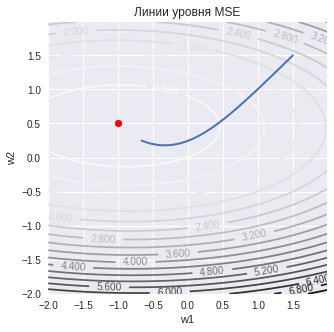

In [0]:
# узкие долины функции
plot_gd(x_scale=0.5, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivM/2kvjn4x%2BDs3gXw18OPh7pniXxD4%2B8Z/8ACP6TYax4jk0u2iK6bf6jLPJPFa3ThVhsJBgRHJZeRXJ/B39vj4ZeLfg8fiP8aXsPBGpWWk%2BJtV1zSo7641C2s9P0PVpdMvLpbr7NF5ieYkbBTGkhEoARtpNAHvFFeXWv7Z/7NV74P1Px9a/EndpOj6Xouo6jd/2PeDybbVlRtPk2mHc3miRDhQWTPzhMGrMv7XP7O0PiXw/4Ol%2BJMK6p4q8Y6n4W0CxNhc%2BZearp/nfbYAPL%2BVYvIkBmbEROwByZEDAHpFFeb/Dn9rn9nb4t%2BLfDHgT4e/EmHUdY8ZfDiLx74dsFsLmOS58OyPBHHfN5ka%2BSGe5hAjk2SHc3yfI%2B23d/tN/A%2BytdSurrxtt/sjx1aeDdQh/sy5MsWt3L2yQWnliPe2/7XbuJFBjEcnmlxGGcAHe0V4p8P/8Agol%2Bx18TfDb%2BMvC3xeZNHHg2XxXBq2seHdR021u9Gi8vz7u3lvLeJLlYmliSURF2ieRUkCswWrNz%2B3r%2BzHZeHZPEV54o8RRNDr9pokmiyfD3W11cX11E01tH/Zps/tmJY0dkk8nYwRsMcGgD2KivNPB/7YP7O3jzyE8MeP3mln0DV9Z%2BzT6LewTQ2ml3aWeoedFLCrwSwXEiRPBIFmDZGw7Wxhan/wAFB/2T9Lk04P4%2B1a5h1O30WaO/03wRrF3aWq6uYhpou7iC0eKyeczw7UuGjYCRSQAQaAPaKK8Y/ai/bAs/2YviT8LPBms%2BBH1LTfiL4qOjahrSal5P9hhjFFDcNH5becjXE8EbfNHsVzISQpB4v4tf8FK/DHwo%2BLHxc8AXfwwur7S/hJ4Gt9a1LXodWRBd30hhL2XltHtijiiurSR7lpCqiSTKDyiSAfTdFfOfjT9sn45fDX4KeJfjD4w/Z08L3trpunadc%2BG9S8JfFIajo%2BsPdXqWnkNdtp8U0EiGRZCy200bIeH3ZUer/DDXf2i9W1O5i%2BNHwr8FaBZpADZz%2BF/H95q8ssu4ZV459KsxGuMncHY54296AO1ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKpeIdRn0rSJdQtlQvHtwHBIOWA7EetNK7sBdorjf8AhYetf8%2Btr/3w3/xVH/Cw9a/59bX/AL4b/wCKrT2MxcyOyorjf%2BFh61/z62v/AHw3/wAVR/wsPWv%2BfW1/74b/AOKo9jMOZHZUVyeo%2BPNWstQntEgtSsUzICyNkgEj%2B9UB%2BI%2BrDrDaf98t/wDFUexmF0dnRXF/8LJ1X/nlZ/8AfLf/ABVH/CytU/552X5N/wDFUexmHMjtKK5B/iFqK2EV2Fs9zzOhGDgBQhH8X%2B0ai/4WTqv/ADys/wDvlv8A4qj2UwujE8f/AAg8bfED9p3wD8SL%2BfS4fCfgHT9SvrVFu5HvrvWruE2a5i8oRxwRWklz8/mM7vc7diCPdJ88aV/wTT%2BL954h8HWvi7xn4abw3otv41fxFp1rcXDvqk2o%2BJjrWlQ/NCoEMci28s5JzvthGFkjdmr6j/4WPq56QWn/AHy3/wAVSj4iayelta/98N/8VR7GYcyPkeb/AIJS/EfVPhxrOk6x45tk12Xwd4A0nRhpnjnWbTTTNokUCXjXdrAEhuUcxt5JlilPIyI%2B3W%2BBf%2BCenxS0b44Q/Gnxd4u8P3txp3x11PxLoVvDNPjT/Dl0NVmaFN0XN7NdahE0wGIzHaQAOTEC30jY%2BO9Yup2ie3tgBDI/CN1VGYfxe1Q/8LD1r/n1tf8Avhv/AIqj2Mwuj51/YL/4J6/FL9lzU/hN4u%2BJni7w/rGveE/g9q3hLxjfaXNOVmmc%2BGYNNitBJEpNrDaaFIrlvLJmmMgjzNJsUfC2x%2BJH/BVm713wR4usdR8J%2BG9EsfEnj3SrNvNFn4xgt7vTLASsp2iV9Ou3kaJsun9n2chCh0J%2Bif8AhYetf8%2Btr/3w3/xVH/Cw9a/59bX/AL4b/wCKo9jMOZHwh%2Byx%2Bxn8ef2sP2C/gdL4q1rwj4f0nw/%2BzpFYeCL7Try5uri/vb6LSbmCS%2Bt2giW3hhGnpG6RzTGcys%2BYtoQ%2Bq/HD9iH9p747eJr741eJLLwbY%2BJbzxT4Um/4RbRPiTrGn2yaZoqaq2V1i2sI7qK6lm1aY5jt1CpEi725J%2Bmv%2BFh61/z62v8A3w3/AMVU19471i1nWJLe2IMMb8o3VkVj/F70exmF0fKHhD/gl98Q7j%2Byh8Q/GaW1vp/gjxvp9vZ%2BGPiHrdrPbXms61b6haxTX9v9nuNVijjjlE9xdfvJ5SJHikYlhBcf8EuPifr3hCyOs%2BL9M07WtE0b4c6Xp1joHi7VbfS9T/sG5sbi%2Bv8AUYY0SO8uHWGa3tllhkVI4IGLI0h8n6w/4WHrX/Pra/8AfDf/ABVH/Cw9a/59bX/vhv8A4qj2Mw5kcF%2B15%2BybeftS6z4dsLrV7Wz0Wz0LxFp2qymV1uom1CwFvBPbBVI8yKQCQEspUqpXJFee/Cb9jD9pz4aRyeP/APhO/A91471bwBcw%2BJ769tLi5sL7xBea02pXiGLYjGxMbvaRuSJI41jPlHZtPsGufFf4hrrcdho40u3hkYRJJe6TLIGl2lsBluEJG0f3cZB57VTf4q/F9Uvm/tHwwv2AI0xk0W6UENv6H7RzyhFS6ckFz518c/8ABNH4k%2BNPDvxGl8GfB34RfDX/AITHwvZabN8P/CWvXcuha9eRarbXrX%2BoMNMt0ilEUElupS0lZluJC7sNqr79%2BzB8FdS%2BEfiPU5Yv2M/gt8MLO/slE9/8L9bM9zeyI48uKaP%2BxbEGMBpGDGRyDwE%2BYsGyfGn41pCZAfC28OUa3bSbzzFIUMSVEpOMEHPuKuQ/Ej9oWaJZ4YvBMqOoZWEd2uQf%2BBGjkm%2BgXR6/RXkX/Czf2hI/v%2BHfCMn/AFzuLkfzqS1%2BK/x7luorY/DvQZjJIqgRaq6ZycdWHFHs59guj1mivIv%2BF2/G1OJPg/YP7x64v9QKP%2BF8fFuPm4%2BDBH/XLUon/wDZ6PZyC6PXaK8iP7RHjuL/AI%2BfhDqQ/wCuUaP/AClrotI%2BKeu6rpsWoSaKto0q5NvdwlZE5xhgHOPzpqlJhdHd0VwGofFTxAdVtNL0W0s5SF8zU5HifbAuWwgIf75Gwgc4ByeozzupftGeIbfVp7G0tdNASOYRRT20wkLoyLuPzgbSWY4HULnIpezkguew0V5Yvxs8Xy%2BKpPDsdlpqqgkPmtBIcbYYXwf3n96UfgPxrV8PfFXX9Y0O01WaxtEa4t1kZVR8DIz/AHqapTYXR31FYHgrxknim4vrRrm

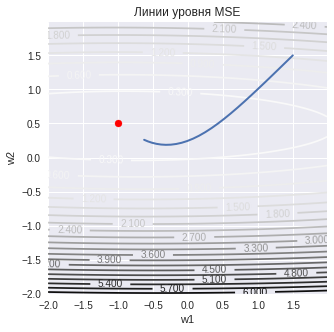

In [0]:
# еще более узкие
plot_gd(x_scale=0.2, lr=0.1, steps=25, optimizer='adam')

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivM/2kvjn4x%2BDs3gXw18OPh7pniXxD4%2B8Z/8ACP6TYax4jk0u2iK6bf6jLPJPFa3ThVhsJBgRHJZeRXJ/B39vj4ZeLfg8fiP8aXsPBGpWWk%2BJtV1zSo7641C2s9P0PVpdMvLpbr7NF5ieYkbBTGkhEoARtpNAHvFFeXWv7Z/7NV74P1Px9a/EndpOj6Xouo6jd/2PeDybbVlRtPk2mHc3miRDhQWTPzhMGrMv7XP7O0PiXw/4Ol%2BJMK6p4q8Y6n4W0CxNhc%2BZearp/nfbYAPL%2BVYvIkBmbEROwByZEDAHpFFeb/Dn9rn9nb4t%2BLfDHgT4e/EmHUdY8ZfDiLx74dsFsLmOS58OyPBHHfN5ka%2BSGe5hAjk2SHc3yfI%2B23d/tN/A%2BytdSurrxtt/sjx1aeDdQh/sy5MsWt3L2yQWnliPe2/7XbuJFBjEcnmlxGGcAHe0V4p8P/8Agol%2Bx18TfDb%2BMvC3xeZNHHg2XxXBq2seHdR021u9Gi8vz7u3lvLeJLlYmliSURF2ieRUkCswWrNz%2B3r%2BzHZeHZPEV54o8RRNDr9pokmiyfD3W11cX11E01tH/Zps/tmJY0dkk8nYwRsMcGgD2KivNPB/7YP7O3jzyE8MeP3mln0DV9Z%2BzT6LewTQ2ml3aWeoedFLCrwSwXEiRPBIFmDZGw7Wxhan/wAFB/2T9Lk04P4%2B1a5h1O30WaO/03wRrF3aWq6uYhpou7iC0eKyeczw7UuGjYCRSQAQaAPaKK8Y/ai/bAs/2YviT8LPBms%2BBH1LTfiL4qOjahrSal5P9hhjFFDcNH5becjXE8EbfNHsVzISQpB4v4tf8FK/DHwo%2BLHxc8AXfwwur7S/hJ4Gt9a1LXodWRBd30hhL2XltHtijiiurSR7lpCqiSTKDyiSAfTdFfOfjT9sn45fDX4KeJfjD4w/Z08L3trpunadc%2BG9S8JfFIajo%2BsPdXqWnkNdtp8U0EiGRZCy200bIeH3ZUer/DDXf2i9W1O5i%2BNHwr8FaBZpADZz%2BF/H95q8ssu4ZV459KsxGuMncHY54296AO1ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKpeIdRn0rSJdQtlQvHtwHBIOWA7EetNK7sBdorjf8AhYetf8%2Btr/3w3/xVH/Cw9a/59bX/AL4b/wCKrT2MxcyOyorjf%2BFh61/z62v/AHw3/wAVR/wsPWv%2BfW1/74b/AOKo9jMOZHZUVyeo%2BPNWstQntEgtSsUzICyNkgEj%2B9UB%2BI%2BrDrDaf98t/wDFUexmF0dnRXF/8LJ1X/nlZ/8AfLf/ABVH/CytU/552X5N/wDFUexmHMjtKK5B/iFqK2EV2Fs9zzOhGDgBQhH8X%2B0ai/4WTqv/ADys/wDvlv8A4qj2UwujE8f/AAg8bfED9p3wD8SL%2BfS4fCfgHT9SvrVFu5HvrvWruE2a5i8oRxwRWklz8/mM7vc7diCPdJ88aV/wTT%2BL954h8HWvi7xn4abw3otv41fxFp1rcXDvqk2o%2BJjrWlQ/NCoEMci28s5JzvthGFkjdmr6j/4WPq56QWn/AHy3/wAVSj4iayelta/98N/8VR7GYcyPkeb/AIJS/EfVPhxrOk6x45tk12Xwd4A0nRhpnjnWbTTTNokUCXjXdrAEhuUcxt5JlilPIyI%2B3W%2BBf%2BCenxS0b44Q/Gnxd4u8P3txp3x11PxLoVvDNPjT/Dl0NVmaFN0XN7NdahE0wGIzHaQAOTEC30jY%2BO9Yup2ie3tgBDI/CN1VGYfxe1Q/8LD1r/n1tf8Avhv/AIqj2Mwuj51/YL/4J6/FL9lzU/hN4u%2BJni7w/rGveE/g9q3hLxjfaXNOVmmc%2BGYNNitBJEpNrDaaFIrlvLJmmMgjzNJsUfC2x%2BJH/BVm713wR4usdR8J%2BG9EsfEnj3SrNvNFn4xgt7vTLASsp2iV9Ou3kaJsun9n2chCh0J%2Bif8AhYetf8%2Btr/3w3/xVH/Cw9a/59bX/AL4b/wCKo9jMOZHwh%2Byx%2Bxn8ef2sP2C/gdL4q1rwj4f0nw/%2BzpFYeCL7Try5uri/vb6LSbmCS%2Bt2giW3hhGnpG6RzTGcys%2BYtoQ%2Bq/HD9iH9p747eJr741eJLLwbY%2BJbzxT4Um/4RbRPiTrGn2yaZoqaq2V1i2sI7qK6lm1aY5jt1CpEi725J%2Bmv%2BFh61/z62v8A3w3/AMVU19471i1nWJLe2IMMb8o3VkVj/F70exmF0fKHhD/gl98Q7j%2Byh8Q/GaW1vp/gjxvp9vZ%2BGPiHrdrPbXms61b6haxTX9v9nuNVijjjlE9xdfvJ5SJHikYlhBcf8EuPifr3hCyOs%2BL9M07WtE0b4c6Xp1joHi7VbfS9T/sG5sbi%2Bv8AUYY0SO8uHWGa3tllhkVI4IGLI0h8n6w/4WHrX/Pra/8AfDf/ABVH/Cw9a/59bX/vhv8A4qj2Mw5kcF%2B15%2BybeftS6z4dsLrV7Wz0Wz0LxFp2qymV1uom1CwFvBPbBVI8yKQCQEspUqpXJFee/Cb9jD9pz4aRyeP/APhO/A91471bwBcw%2BJ769tLi5sL7xBea02pXiGLYjGxMbvaRuSJI41jPlHZtPsGufFf4hrrcdho40u3hkYRJJe6TLIGl2lsBluEJG0f3cZB57VTf4q/F9Uvm/tHwwv2AI0xk0W6UENv6H7RzyhFS6ckFz518c/8ABNH4k%2BNPDvxGl8GfB34RfDX/AITHwvZabN8P/CWvXcuha9eRarbXrX%2BoMNMt0ilEUElupS0lZluJC7sNqr79%2BzB8FdS%2BEfiPU5Yv2M/gt8MLO/slE9/8L9bM9zeyI48uKaP%2BxbEGMBpGDGRyDwE%2BYsGyfGn41pCZAfC28OUa3bSbzzFIUMSVEpOMEHPuKuQ/Ej9oWaJZ4YvBMqOoZWEd2uQf%2BBGjkm%2BgXR6/RXkX/Czf2hI/v%2BHfCMn/AFzuLkfzqS1%2BK/x7luorY/DvQZjJIqgRaq6ZycdWHFHs59guj1mivIv%2BF2/G1OJPg/YP7x64v9QKP%2BF8fFuPm4%2BDBH/XLUon/wDZ6PZyC6PXaK8iP7RHjuL/AI%2BfhDqQ/wCuUaP/AClrotI%2BKeu6rpsWoSaKto0q5NvdwlZE5xhgHOPzpqlJhdHd0VwGofFTxAdVtNL0W0s5SF8zU5HifbAuWwgIf75Gwgc4ByeozzupftGeIbfVp7G0tdNASOYRRT20wkLoyLuPzgbSWY4HULnIpezkguew0V5Yvxs8Xy%2BKpPDsdlpqqgkPmtBIcbYYXwf3n96UfgPxrV8PfFXX9Y0O01WaxtEa4t1kZVR8DIz/AHqapTYXR31FYHgrxknim4vrRrm

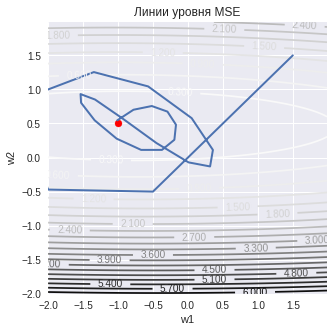

In [0]:
# сломает ли его шаг побольше?
# слишком большие шаги, закручиваемся вокруг решения из-за момента
plot_gd(x_scale=0.2, lr=2.0, steps=25, optimizer='adam')

Если хочется почитать подробнее: http://cnl.salk.edu/~schraudo/teach/NNcourse/precond.html